In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

import walk
from experiment import MultipleExperiment, SingleExperiment

# The Simulation Code for Random Walk


## General Realization

We chose OOP (object oriented programming) approach because it provides

    1. code reusability
    2. code readability and ease of maintainance
    3. easily implement new types of walk

limitations of this coding decision include

    1. slower compared to functional / procedual approach
    2. hard to vectorize, not optimal for parallel execution / batch simulation

To cope with the performance limitations, we can

    1. use multi-threading to obtain more efficiency, although still slower than vectorized execution
    2. write separate, vectorizable code when there is a real need

In [2]:
import random
from typing import Dict


class RandomWalk():
    class EdgeProperty():
        '''
            Sometimes we give each edge some property that may be subject to change.

            Examples of edge properties are:
            1. In simple random walk there is no edge property
            2. In Edge Reinforced RW we need to store the number of time each edge is visited
        '''
        @classmethod
        def default(cls, position: int):
            return None

    class Step():
        '''
            Describes the change to system state when one action is taken.

            weight: Used to determine probability to choosing this step
            age: system age after this step
            modified_edges: change to edge properties after this step
            position: new position after this step
        '''

        def __init__(self, weight: float, t: int, modified_edges: dict, position: int) -> None:
            self.weight: float = weight
            self.t: int = t
            self.modified_edges: Dict[int,
                                      RandomWalk.EdgeProperty] = modified_edges
            self.position: int = position

    def __init__(self, _random_seed: bytes = None) -> None:
        # steps of simulation so far
        self.t: int = 0
        # current edge properties that are not default
        self.modified_edges: Dict[int, RandomWalk.EdgeProperty] = dict()
        # current step of the walker
        self.position: int = 0
        # used to make pseudoranodm choices.
        self._random_seed: bytes =\
            _random_seed if _random_seed else random.randbytes(32)

    def get_edge_property(self, position: int) -> EdgeProperty:
        if position in self.modified_edges:
            return self.modified_edges[position]
        else:
            return self.__class__.EdgeProperty.default(position)

    def choose_step(self) -> Step:
        # get steps
        steps = list(self.available_steps())
        steps.sort(key=lambda x: x.position)

        # choose a step

        # use t to make sure each step is different
        random.seed(self._random_seed + self.t.to_bytes(32, 'big'))

        step = random.choices(steps, weights=[x.weight for x in steps])[0]

        # reset the random seed
        random.seed()

        return step

    def take_step(self, step: Step):
        # update
        self.t = step.t
        self.modified_edges.update(step.modified_edges)
        self.position = step.position

    def available_steps(self):
        raise NotImplementedError()




## Implementations of different walks

In [3]:
class SimpleSymmetricRandomWalk(RandomWalk):
    '''
        In this type of random walk, the walker walk left or right with equal probability.
    '''

    def available_steps(self):
        Step = RandomWalk.Step
        yield from [
            Step(
                weight=1,
                t=self.t + 1,
                modified_edges=dict(),  # no edge property
                position=position
            ) for position in [self.position-1, self.position+1]]


class SimpleAsymmetricRandomWalk(RandomWalk):
    '''
        In this type of random walk, the walker walk left or right with probability 1-p and p respectively.
    '''

    def __init__(self, p: float = 0.5, _random_seed: bytes = None):
        super().__init__(_random_seed)
        self.p: float = p

    def available_steps(self):
        Step = RandomWalk.Step
        yield from [
            Step(
                weight=1-self.p,
                t=self.t + 1,
                modified_edges=dict(),  # no edge property
                position=self.position-1
            ),
            Step(
                weight=self.p,
                t=self.t + 1,
                modified_edges=dict(),  # no edge property
                position=self.position+1
            )
        ]


class LinearEdgeReinforcedRandomWalk(RandomWalk):
    class EdgeProperty(RandomWalk.EdgeProperty, int):
        '''
            This is the number of times this edge is visited.
        '''
        @classmethod
        def default(cls, position: int):
            return cls(1)

    def available_steps(self):
        Step = RandomWalk.Step
        n = self.position
        left, right = self.get_edge_property(n-1), self.get_edge_property(n)

        # left
        yield Step(
            weight=left,
            t=self.t + 1,
            modified_edges={n-1: left+1},
            position=n-1)

        # right
        yield Step(
            weight=right,
            t=self.t + 1,
            modified_edges={n: right+1},
            position=n+1)

# Simple Asymmetric Random Walk

We provide an analysis to the simple random walk to demonstrate how our code works.

## Simulation of the Walk

With the current setup it's very easy to create and run a walk.

In [4]:
test = SingleExperiment(walk.SimpleAsymmetricRandomWalk(0.8))
test.run(100)

In [5]:
test.data

,1
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
...,...
95,64.0
96,63.0
97,64.0
98,63.0


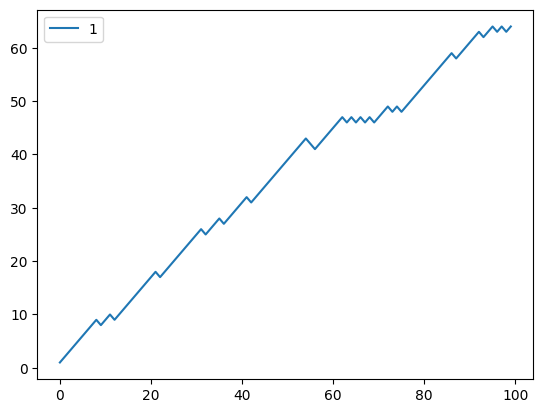

In [6]:
test.plot()

## Normality Test on the simple asymmetric random walk

In this walk, $X_i = \pm 1$ with probability $p$ and $1-p$ respectively.

Since $X_1, \ldots, X_n$ are all i.i.d, we can use central limit theorem for i.i.d sequences. Assume $p\neq \frac{1}{2}$,
$$
\left(S_n-n \mu\right) / \sigma n^{1 / 2} \Rightarrow \chi
$$
where $\chi$ has the standard normal distribution.

Now 
$$n \mu = n (2p-1)$$
, and 
$$\sigma = \sqrt{4p(1-p)}$$
. Therefore we should expect, when $n = 100$ and $p = 0.8$, the following distribution:


Text(0.5, 1.0, 'Normal distribution with mean 600.00 and variance 20.24')

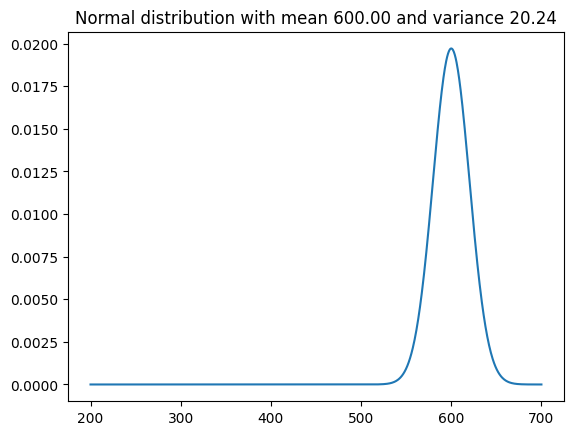

In [7]:
n = 1000
p = 0.8
mu = 2 * p - 1
sigma = np.sqrt(4 * p * (1 - p))
range = np.linspace(200,700,1000)
plt.plot(range, scipy.stats.norm.pdf(range, n * mu, sigma**2 * np.sqrt(n)))
plt.title(f"Normal distribution with mean {n * mu:.2f} and variance {sigma**2 * np.sqrt(n):.2f}")

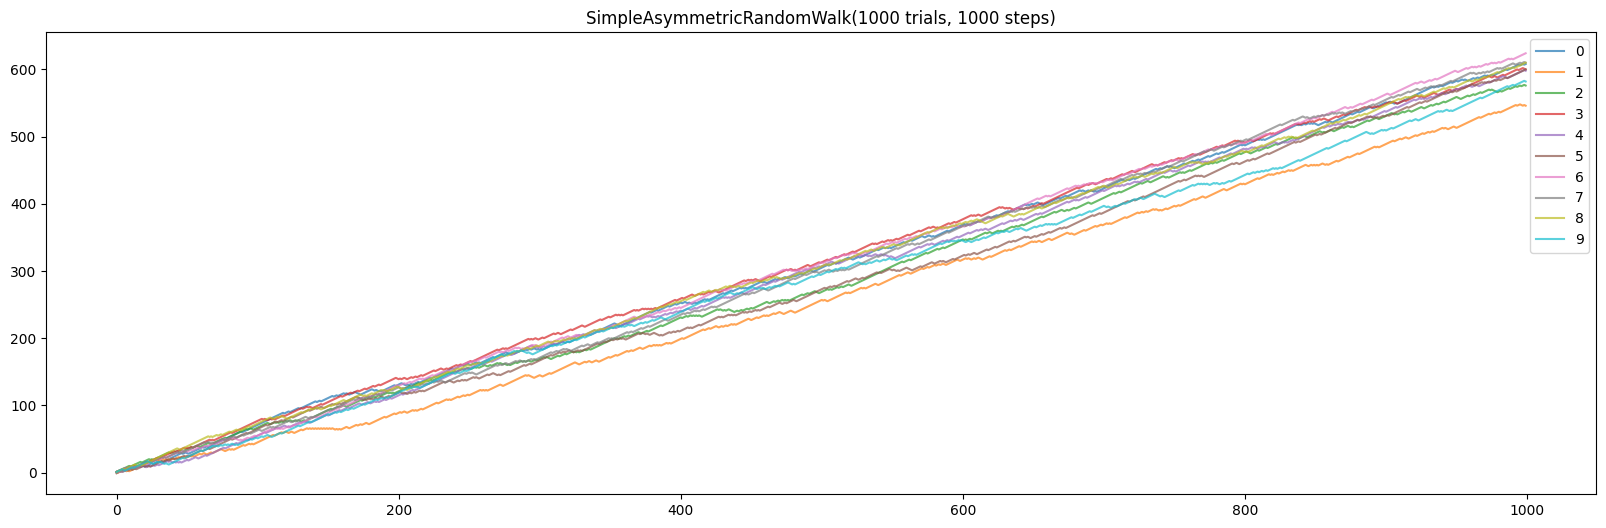

In [8]:
test = MultipleExperiment(
    walk.SimpleAsymmetricRandomWalk,
    p=0.8,
    n_trials=1000,
    length=1000)
test.run()
test.plot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

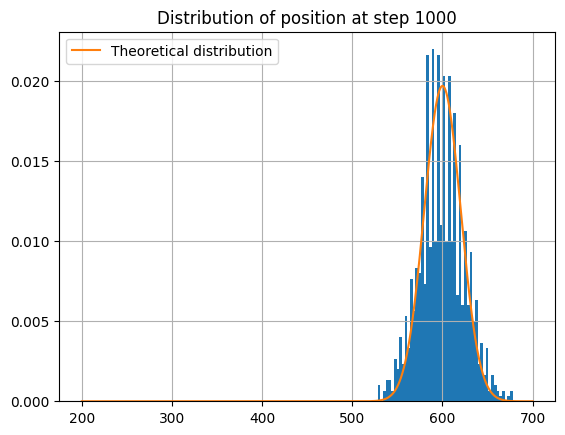

In [9]:
test.data.iloc[-1, :].hist(bins=50, density= True)
plt.title(f"Distribution of position at step {test.length}")
plt.plot(range, scipy.stats.norm.pdf(range, n * mu, sigma**2 * np.sqrt(n)), label="Theoretical distribution")
plt.legend()

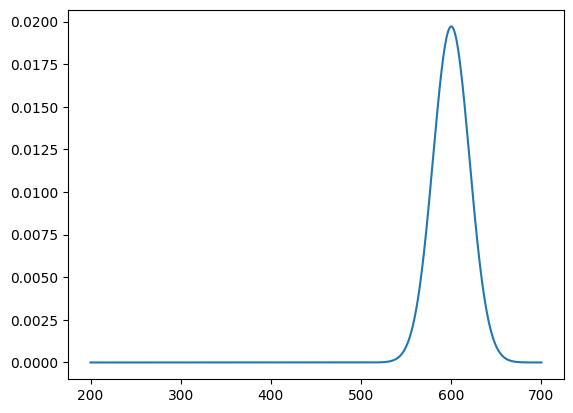

In [10]:
plt.plot(range, scipy.stats.norm.pdf(range, n * mu, sigma**2 * np.sqrt(n)), label="Theoretical distribution")

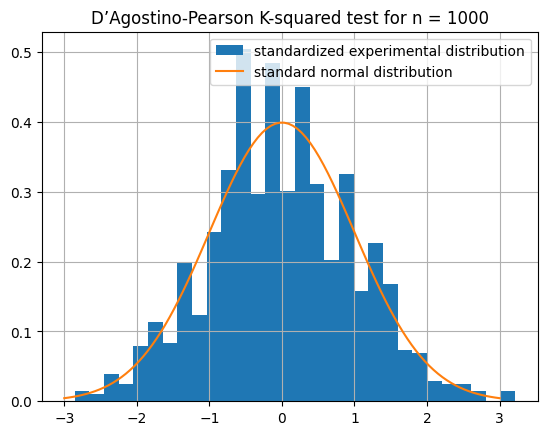

In [11]:
((test.data.iloc[-1, :]
    - test.data.iloc[-1, :].mean())
    / (test.data.iloc[-1, :].std())
 ).hist(
    bins=min(30, int(test.n_trials**(1/2))),
    density=True,
    label='standardized experimental distribution'
    )
plt.title(f'D’Agostino-Pearson K-squared test for n = {test.length}')
range = np.linspace(-3, 3, 100)
plt.plot(range, scipy.stats.norm.pdf(range, 0, 1), label='standard normal distribution')
plt.legend()

In [12]:

test.test()

Statistic: 0.6186528163636981, p-value: 0.73394116652237


### Conclusion for statistical testing:
We **fail to reject the null hypothesis** that the limiting distribution is normal via the K-Squared test at the significance level of 0.01.


# Linear Edge Reinforced Random Walk

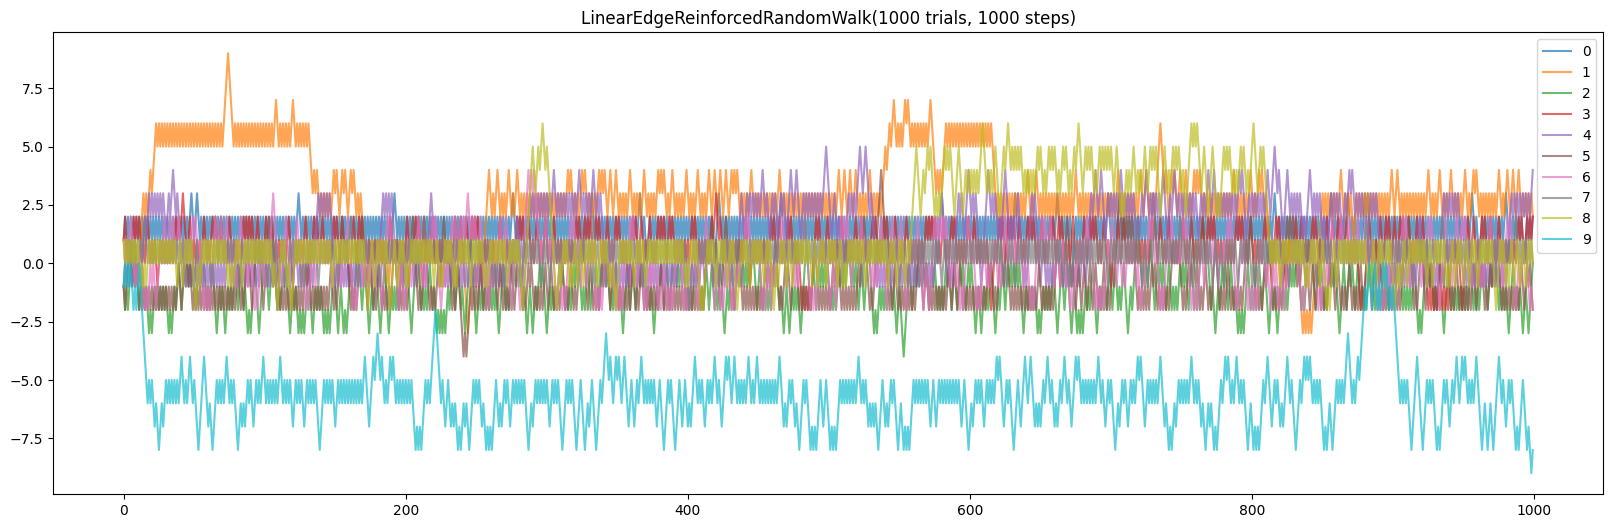

In [13]:
test = MultipleExperiment(
    walk.LinearEdgeReinforcedRandomWalk,
    n_trials=1000,
    length=1000)
test.run()
test.plot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
test.data

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0
1,2.0,0.0,-2.0,2.0,0.0,-2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,2.0
2,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,...,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-3.0,-1.0,3.0
3,2.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,2.0
4,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,...,1.0,3.0,-1.0,-1.0,-1.0,-1.0,1.0,-3.0,-3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.0,2.0,-2.0,2.0,2.0,0.0,0.0,0.0,0.0,-8.0,...,0.0,0.0,0.0,6.0,-2.0,-12.0,-2.0,0.0,0.0,0.0
996,1.0,3.0,-3.0,1.0,3.0,-1.0,-1.0,1.0,1.0,-7.0,...,1.0,1.0,-1.0,7.0,-1.0,-11.0,-1.0,1.0,-1.0,1.0
997,2.0,2.0,-2.0,2.0,2.0,0.0,-2.0,0.0,0.0,-8.0,...,2.0,0.0,0.0,6.0,-2.0,-12.0,0.0,2.0,-2.0,0.0
998,1.0,3.0,-1.0,1.0,3.0,-1.0,-1.0,1.0,1.0,-9.0,...,1.0,-1.0,1.0,7.0,-1.0,-11.0,-1.0,1.0,-1.0,-1.0


### The distribution of $S_{1000}$, and a hypothesis test for normal distribution

<AxesSubplot:>

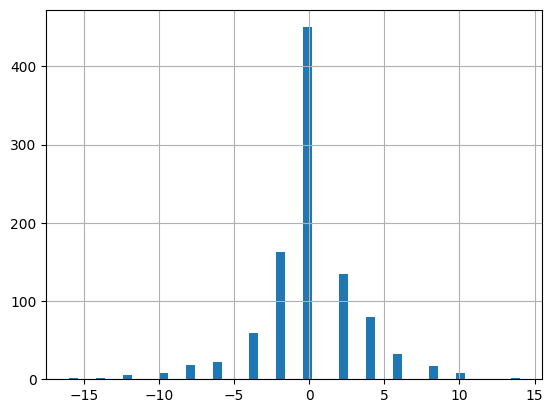

In [15]:
test.data.iloc[-1, :].hist(bins=50)

The D’Agostino-Pearson $k^2$ test:

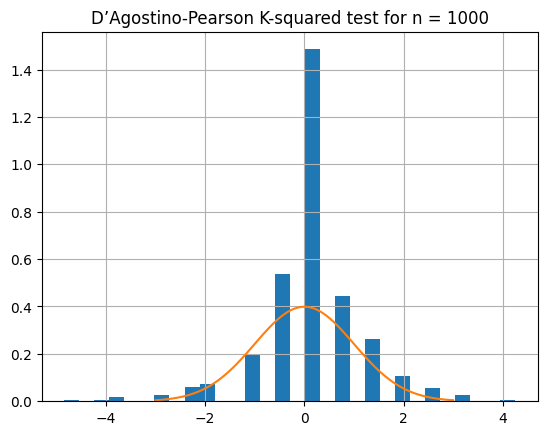

In [16]:
((test.data.iloc[-1, :]
    - test.data.iloc[-1, :].mean())
    / (test.data.iloc[-1, :].std())
 ).hist(
    bins=min(30, int(test.n_trials**(1/2))),
    density=True)
plt.title(f'D’Agostino-Pearson K-squared test for n = {test.length}')
range = np.linspace(-3, 3, 100)
plt.plot(range, scipy.stats.norm.pdf(range, 0, 1))

In [17]:
test.test()

Statistic: 99.48720667387322, p-value: 2.4924563469330215e-22


## Conclusion for statistical testing:
We **reject the null hypothesis** that the limiting distribution is normal via the K-Squared test at the significance level of 0.01.
